# Part 1: Transformers

## Task 1 (30 points):
In this task you should work with the Facebook BART model
(https://huggingface.co/docs/transformers/en/model_doc/bart) to provide text summarization
of news articles. Text summarization in Natural Language Processing (NLP) is a technique that
breaks down long texts into sentences or paragraphs, while retaining the text's meaning and
extracting important information. Pick any one dataset of your choice.

You may have to do data cleaning, preprocessing etc. Next, perform the following tasks:

  1. Provide a description of the dataset you selected. Split your data into train-test set with a (90-10) split.
  2. Load the model from Hugging Face’s Transformers library and write its training script.
  3. Fine tune the pre-trained model with your data and report results on your test set. You must report the BLEU and ROUGE Scores. (See the code provided in class for more details)
  4. Analyze your results and discuss the impact of hyperparameters. Are your results impacted by the choice of the LLM here? How?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings("ignore") 

In [2]:
pip install lightning --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 13.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [45]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

In [46]:
pip install rouge --quiet

Note: you may need to restart the kernel to use updated packages.


In [47]:
import transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer, AutoModel
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, BartForConditionalGeneration
from transformers import DataCollatorForSeq2Seq, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import create_optimizer, AdamWeightDecay
from transformers import pipeline
import datasets
from datasets import Dataset, DatasetDict
#from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from rouge import Rouge

In [48]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [49]:
df = pd.read_csv("/kaggle/input/news-summary/news_summary.csv", encoding="latin-1")
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [50]:
df.describe()

,author,date,headlines,read_more,text,ctext
count,4514,4514,4514,4514,4514,4396
unique,45,240,4514,4461,4514,4341
top,Chhavi Tyagi,"19 Jul 2017,Wednesday",More than half of India's languages may die in...,http://indiatoday.intoday.in/story/assembly-el...,At least 400 languages or more than half langu...,AAJ TAK LIVE TV WITH LIVE ELECTION RESULTS I c...
freq,559,76,1,13,1,13


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     4514 non-null   object
 1   date       4514 non-null   object
 2   headlines  4514 non-null   object
 3   read_more  4514 non-null   object
 4   text       4514 non-null   object
 5   ctext      4396 non-null   object
dtypes: object(6)
memory usage: 211.7+ KB


In [52]:
df = df[['headlines', 'text', 'ctext']]
df.head()

,headlines,text,ctext
0,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika slams user who trolled her for 'divorc...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Aaj aapne pakad liya: LeT man Dujana before be...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotel staff to get training to spot signs of s...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [53]:
# drop na
df = df.dropna()
df.describe()

,headlines,text,ctext
count,4396,4396,4396
unique,4396,4396,4341
top,More than half of India's languages may die in...,At least 400 languages or more than half langu...,AAJ TAK LIVE TV WITH LIVE ELECTION RESULTS I c...
freq,1,1,13


In [54]:
# Converting to lowercase
df['ctext'] = df['ctext'].apply(str.lower)
df['text'] = df['text'].apply(str.lower)
df['headlines'] = df['headlines'].apply(str.lower)
df.head()

,headlines,text,ctext
0,daman & diu revokes mandatory rakshabandhan in...,the administration of union territory daman an...,the daman and diu administration on wednesday ...
1,malaika slams user who trolled her for 'divorc...,malaika arora slammed an instagram user who tr...,"from her special numbers to tv?appearances, bo..."
2,'virgin' now corrected to 'unmarried' in igims...,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...
3,aaj aapne pakad liya: let man dujana before be...,lashkar-e-taiba's kashmir commander abu dujana...,lashkar-e-taiba's kashmir commander abu dujana...
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...,hotels in mumbai and other indian cities are t...


In [55]:
df['headlines_length'] = [len(x.split()) for x in df.headlines]
df['text_length'] = [len(x.split()) for x in df.text]
df['ctext_length'] = [len(x.split()) for x in df.ctext]
df.head()

,headlines,text,ctext,headlines_length,text_length,ctext_length
0,daman & diu revokes mandatory rakshabandhan in...,the administration of union territory daman an...,the daman and diu administration on wednesday ...,9,60,364
1,malaika slams user who trolled her for 'divorc...,malaika arora slammed an instagram user who tr...,"from her special numbers to tv?appearances, bo...",10,60,396
2,'virgin' now corrected to 'unmarried' in igims...,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...,8,60,335
3,aaj aapne pakad liya: let man dujana before be...,lashkar-e-taiba's kashmir commander abu dujana...,lashkar-e-taiba's kashmir commander abu dujana...,10,60,404
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...,hotels in mumbai and other indian cities are t...,11,60,526


In [56]:
df = df[df['ctext_length'] >= df['text_length']]
df.describe()

,headlines_length,text_length,ctext_length
count,4274.000000,4274.000000,4274.000000
mean,9.300889,58.299719,351.740056
std,1.407168,2.314246,358.884472
min,4.000000,44.000000,50.000000
25%,8.000000,57.000000,193.000000
50%,9.000000,59.000000,288.000000
75%,10.000000,60.000000,416.000000
max,14.000000,62.000000,12202.000000


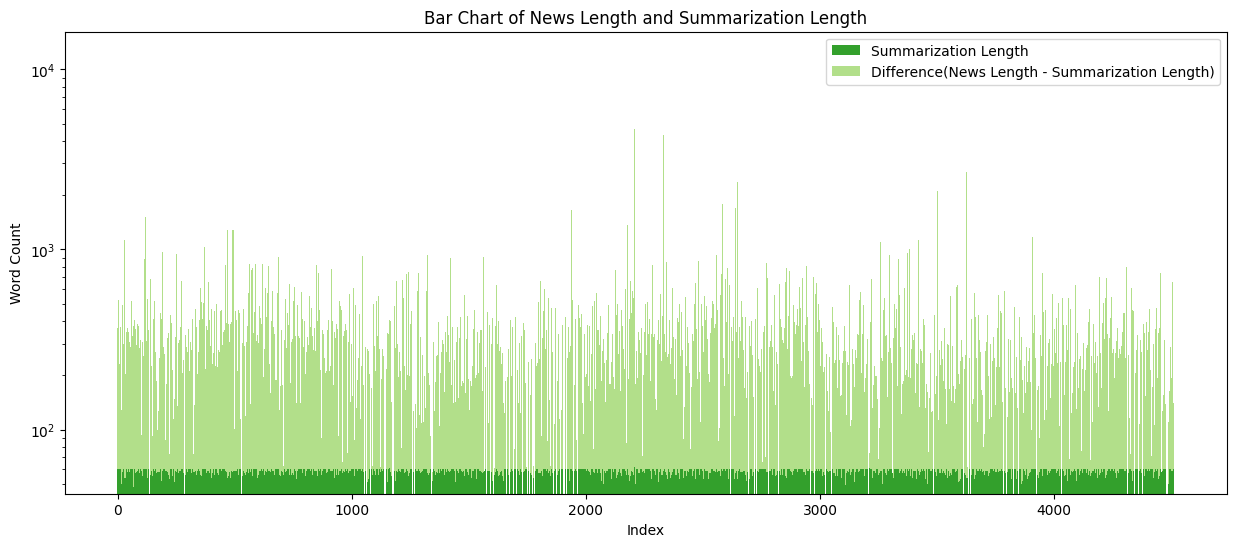

In [57]:
df['diff'] = df['ctext_length'] - df['text_length']
#sns.set(style="whitegrid")
color1 = sns.color_palette("Paired")[3] 
color2 = sns.color_palette("Paired")[2]  

plt.figure(figsize=(15, 6))
bar1 = plt.bar(df.index, df['text_length'], color=color1, label='Summarization Length', width=1.0)
bar2 = plt.bar(df.index, df['diff'], bottom=df['text_length'], color=color2, label='Difference(News Length - Summarization Length)', width=1.0)

plt.xlabel('Index')
plt.ylabel('Word Count')
plt.title('Bar Chart of News Length and Summarization Length')
plt.legend()
plt.yscale('log')
plt.show()

In [58]:
df = df.drop(columns=['headlines_length', 'text_length', 'ctext_length', 'diff'])
df.head()

,headlines,text,ctext
0,daman & diu revokes mandatory rakshabandhan in...,the administration of union territory daman an...,the daman and diu administration on wednesday ...
1,malaika slams user who trolled her for 'divorc...,malaika arora slammed an instagram user who tr...,"from her special numbers to tv?appearances, bo..."
2,'virgin' now corrected to 'unmarried' in igims...,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...
3,aaj aapne pakad liya: let man dujana before be...,lashkar-e-taiba's kashmir commander abu dujana...,lashkar-e-taiba's kashmir commander abu dujana...
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...,hotels in mumbai and other indian cities are t...


In [59]:
df['news'] = df['headlines'] + '. ' + df['ctext']
df.rename(columns={"text": "summary"}, inplace = True)
df = df.drop(columns=['headlines', 'ctext'])
df.head()

,summary,news
0,the administration of union territory daman an...,daman & diu revokes mandatory rakshabandhan in...
1,malaika arora slammed an instagram user who tr...,malaika slams user who trolled her for 'divorc...
2,the indira gandhi institute of medical science...,'virgin' now corrected to 'unmarried' in igims...
3,lashkar-e-taiba's kashmir commander abu dujana...,aaj aapne pakad liya: let man dujana before be...
4,hotels in maharashtra will train their staff t...,hotel staff to get training to spot signs of s...


In [60]:
# Making the dataset
prefix = 'summarize: '
df['news'] = prefix + df['news']
df.head()

,summary,news
0,the administration of union territory daman an...,summarize: daman & diu revokes mandatory raksh...
1,malaika arora slammed an instagram user who tr...,summarize: malaika slams user who trolled her ...
2,the indira gandhi institute of medical science...,summarize: 'virgin' now corrected to 'unmarrie...
3,lashkar-e-taiba's kashmir commander abu dujana...,summarize: aaj aapne pakad liya: let man dujan...
4,hotels in maharashtra will train their staff t...,summarize: hotel staff to get training to spot...


In [61]:
# Converting the pandas dataset to huggingface dataset
# first split the train and test set
train_df, test_df = train_test_split(df, test_size=0.01, shuffle=True)
print("train and val shape:", train_df.shape, "test shape:",test_df.shape)
# save for every model inference
global_train_df = train_df
global_test_df = test_df
train_df = datasets.Dataset.from_pandas(train_df)
train_df = train_df.remove_columns(["__index_level_0__"])
# split train into train and val
train_df = train_df.train_test_split(test_size=0.2, shuffle=True) # split train and test
train_df["train"][0]

train and val shape: (4231, 2) test shape: (43, 2)


{'summary': 'mumbai\'s rizvi education society has reportedly digitised seven schools and colleges in its first phase of digital transformation. it has introduced paperless admissions and biometric entry for students among others. authorities said the parents are "happy" as they can check their child\'s attendance on an app. it reportedly plans to start online checking of exam papers in the second phase.',
 'news': 'summarize: mumbai education society digitises 7 schools and colleges. bandra?s rizvi education society, which manages seven institutes including schools and colleges, recently implemented the first phase of digital transformation of its education and administration system. the institutes now have technology-driven teaching interface in all classrooms, bio-metric entry for students, paperless admissions and mobile apps for better teacher-parent interaction. the education society also plans to introduce online assessment of all examinations soon.?paperless admissions have not

In [62]:
# Fitting into dataset dict
train_val_test_dataset = DatasetDict({
    'train': train_df["train"],
    'val': train_df['test']})

print(type(train_val_test_dataset))
train_val_test_dataset

<class 'datasets.dataset_dict.DatasetDict'>


DatasetDict({
    train: Dataset({
        features: ['summary', 'news'],
        num_rows: 3384
    })
    val: Dataset({
        features: ['summary', 'news'],
        num_rows: 847
    })
})

In [63]:
def prepare_dataset(data):
    inputs = data["news"]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)
    labels = tokenizer(text_target=data["summary"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [64]:
# Free up memory
torch.cuda.empty_cache()

In [65]:
# tokenize the data
model_name = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = False)
tokenized_data = train_val_test_dataset.map(prepare_dataset, batched=True)

Map:   0%|          | 0/3384 [00:00<?, ? examples/s]

Map:   0%|          | 0/847 [00:00<?, ? examples/s]

In [66]:
# Padding
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)

In [67]:
# model
BARTmodel = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [68]:
# set up hyper-parameters
training_args = Seq2SeqTrainingArguments(
    output_dir="bart-news",
    evaluation_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True, 
    report_to="none"
)

In [69]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = Rouge().get_scores(decoded_preds, decoded_labels, avg=True, ignore_empty=True)

    # prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    # result["gen_len"] = np.mean(prediction_lens)

    return result

In [70]:
# setup trainer
trainer = Seq2SeqTrainer(
    model = BARTmodel,
    args = training_args,
    train_dataset = tokenized_data["train"],
    eval_dataset = tokenized_data["val"],
    processing_class = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics
)

In [71]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge-1,Rouge-2,Rouge-l
1,No log,1.429421,"{'r': 0.48011857200580416, 'p': 0.45480930303146755, 'f': 0.4634295162457562}","{'r': 0.25377718897279744, 'p': 0.2376151620265638, 'f': 0.24309207038276226}","{'r': 0.434866174939268, 'p': 0.4125328680220178, 'f': 0.420086756286108}"
2,No log,1.392120,"{'r': 0.4965308227594908, 'p': 0.45416049605087483, 'f': 0.4705258733264303}","{'r': 0.26544853257278306, 'p': 0.2387942380631284, 'f': 0.24889197884748976}","{'r': 0.44891683873113924, 'p': 0.41098257802003607, 'f': 0.4255949374835978}"
3,1.470000,1.382965,"{'r': 0.5024291464198246, 'p': 0.4584699583948406, 'f': 0.4757267839113901}","{'r': 0.27083789713655526, 'p': 0.242360464735477, 'f': 0.2534256354941462}","{'r': 0.4550876259014045, 'p': 0.41566652733509835, 'f': 0.43112241470840446}"


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

TrainOutput(global_step=636, training_loss=1.4518157431164627, metrics={'train_runtime': 3468.999, 'train_samples_per_second': 2.926, 'train_steps_per_second': 0.183, 'total_flos': 1.1000121377292288e+16, 'train_loss': 1.4518157431164627, 'epoch': 3.0})

In [73]:
# Evaluation on Test Set
results = trainer.evaluate(tokenized_data["val"])
print(results)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

{'eval_loss': 1.3829649686813354, 'eval_rouge-1': {'r': 0.5024291464198246, 'p': 0.4584699583948406, 'f': 0.4757267839113901}, 'eval_rouge-2': {'r': 0.27083789713655526, 'p': 0.242360464735477, 'f': 0.2534256354941462}, 'eval_rouge-l': {'r': 0.4550876259014045, 'p': 0.41566652733509835, 'f': 0.43112241470840446}, 'eval_runtime': 687.7112, 'eval_samples_per_second': 1.232, 'eval_steps_per_second': 0.077, 'epoch': 3.0}


In [75]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    bleu_scores = []
    smoothing_function = SmoothingFunction().method4
    for ref, pred in zip(decoded_labels, decoded_preds):
        try:
            bleu_scores.append(sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothing_function))
        except:
            bleu_scores.append(0) # handle cases where bleu returns errors.

    return {
        'bleu': np.mean(bleu_scores) if bleu_scores else 0 #handle empty bleu score lists.
    }

# Setup trainer
trainer = Seq2SeqTrainer(
    model=BARTmodel,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [77]:
# Free up memory
torch.cuda.empty_cache()

In [78]:
# Training
trainer.train()

# Evaluation on Test Set
results = trainer.evaluate(tokenized_data["test"])
print(results)

OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/parallel_apply.py", line 96, in _worker
    output = module(*input, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bart/modeling_bart.py", line 1642, in forward
    outputs = self.model(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bart/modeling_bart.py", line 1528, in forward
    decoder_outputs = self.decoder(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bart/modeling_bart.py", line 1380, in forward
    layer_outputs = decoder_layer(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bart/modeling_bart.py", line 685, in forward
    hidden_states, cross_attn_weights, cross_attn_present_key_value = self.encoder_attn(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bart/modeling_bart.py", line 465, in forward
    key_states = self._shape(self.k_proj(key_value_states), -1, bsz)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/linear.py", line 125, in forward
    return F.linear(input, self.weight, self.bias)
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 16.12 MiB is free. Process 3120 has 14.72 GiB memory in use. Of the allocated memory 13.70 GiB is allocated by PyTorch, and 836.69 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


In [ ]:
# save the model
model_path = "bart-news"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

In [ ]:
model = BartForConditionalGeneration.from_pretrained("bart-news")
tokenizer = AutoTokenizer.from_pretrained("bart-news")

In [ ]:
for i in range(5):
    print("original_news: ",test_df['news'].iloc[i])
    summarizer = pipeline("summarization", model = model,tokenizer = tokenizer, max_length = 100)
    summary = summarizer(test_df['news'].iloc[i])
    print(summary[0])
    print()

# Part 2: Reinforcement Learning

## Task 2(20 points):
We discussed how we can formulate RL problems as an MDP. Describe any
real-world application that can be formulated as an MDP. Describe the state space, action
space, transition model, and rewards for that problem. You do not need to be precise in the
description of the transition model and reward (no formula is needed). Qualitative description
is enough.

### **Action Space (A): A Robot's Arsenal**

The robot's actions dictate its interaction with the environment:

* **Movement:** Forward, backward, left, right, up, and down.
* **Rotation:** Pitch, yaw, and roll adjustments.
* **Sensor Operations:** Scan and analyze the environment.
* **Survivor Interaction:** Pick up and transport.
* **Return to Base:** Initiate homeward journey.

### **Transition Model (P): The Unpredictable Reality**

The transition model, P(s' | s, a), describes the probability of moving from state 's' to 's'' after taking action 'a':

* Movement actions result in position and orientation changes, influenced by obstacles.
* Sensor actions update the robot's environmental knowledge.
* Survivor interactions alter the robot's status.
* Return to base actions trigger a change in position and status.
* This model is inherently stochastic due to the chaotic environment.

### **Reward Function (R): Prioritizing Life**

The reward function, R(s, a, s'), guides the robot's behavior:

* **High Positive Rewards:** Finding survivors.
* **Negative Rewards:** Collisions, battery depletion, and excessive time.
* **Small Negative Rewards:** Each movement step.
* **Rewards:** Accurate environmental mapping.

**Visualizing the State Space**

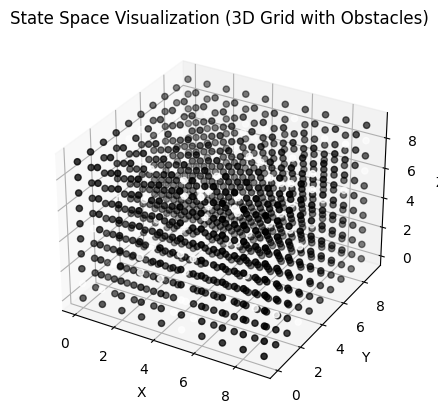

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Example 3D grid for the state space
grid_size = 10
x = np.arange(0, grid_size)
y = np.arange(0, grid_size)
z = np.arange(0, grid_size)
X, Y, Z = np.meshgrid(x, y, z)

# Example obstacles (randomly generated)
obstacles = np.random.choice([0, 1], size=(grid_size, grid_size, grid_size), p=[0.9, 0.1])

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the grid and obstacles
ax.scatter(X, Y, Z, c=obstacles.flatten(), cmap='gray')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.title('State Space Visualization (3D Grid with Obstacles)')
plt.show()

## Task 3(20 points): 
RL is used in various sectors - Healthcare, recommender systems and trading
are a few of those. Pick one of the three areas. Explain one of the problems in any of these
domains that can be more effectively solved by reinforcement learning. Find an open-source
project (if any) that has addressed this problem. Explain this project in detail.

[AI Clinician (Sepsis Treatment)](https://github.com/microsoft/mimic_sepsis)

**Reinforcement Learning in Healthcare: Optimizing Sepsis Treatment with the AI Clinician Project**

Problem Addressed: Dynamic Treatment Optimization for Sepsis

Sepsis, a life-threatening response to infection, requires precise management of intravenous (IV) fluids and vasopressors in intensive care units (ICUs). Traditional protocols often follow fixed guidelines, failing to account for individual patient variability or long-term outcomes. Reinforcement learning (RL) excels here by:

Learning personalized treatment policies from historical patient trajectories 1016.
Balancing exploration (trying new actions) and exploitation (using known effective treatments) 12.
Optimizing sequential decisions (e.g., adjusting vasopressor doses hourly) to maximize survival rates 15.

**Technical Details of the Project**

1. **Data Pipeline:**
* Uses MIMIC-III (60,000+ ICU admissions) and eICU datasets 57.
* Preprocesses irregular time-series data (e.g., vitals, lab results) with custom imputation (kNN + linear interpolation) 10.
2. **RL Framework:**
* States: 53 clinical features (e.g., blood pressure, lactate) clustered into discrete categories 10.
* Actions: Dosages of IV fluids and vasopressors (discretized into bins) 16.
Reward: Survival-to-discharge (+1), death (−1), and penalties for adverse effects 12.
* Algorithm: Initially used SARSA (discrete states) 5; later works adopted Deep Q-Networks (DQN) for continuous states 1516.
3. **Key Innovations:**
* Risk-Aware Policies: Distributional RL accounts for uncertainty in patient responses 10.
* Transfer Learning: Policies trained on US (MIMIC-III) data generalized to European (AmsterdamUMCdb) ICUs 15.
* Interpretability: Attention maps and feature importance (e.g., random forest) explain treatment decisions 16.

**Results and Impact**

* 3–15% higher survival rates compared to clinician policies 1016.
* More conservative fluid use and earlier vasopressor administration—aligning with later clinical guidelines 15.
* Open challenges: Data bias (e.g., underrepresentation of ethnic groups) and real-world deployment barriers 712.

# Part 3: Recommender Systems

## Task 5 (30 points): 
For this task use the MovieLens 100k dataset
[link]((https://grouplens.org/datasets/movielens/100k/))

Perform the necessary data cleaning, EDA and conversion to User-item matrix.

Implement any 2 collaborative filtering recommendation systems (RecSys) algorithms covered
in class (Matrix Factorization, Alternating Least Squares, NCF etc.) and compare their
performance for any 2-evaluation metrics used for RecSys. You may read literature to find out
which evaluation metrics are used for RecSys. Cite all your research.

In [81]:
datafile = '/kaggle/input/movielens100k/ml-100k/u.data'

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load data
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(datafile, sep='\t', names=column_names)

# EDA and Data Cleaning
print(df.head())
print(df.info())
print(df.describe())# Basic EDA

# Check for missing values
print(df.isnull().sum())

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
None
            user_id        item_id         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e

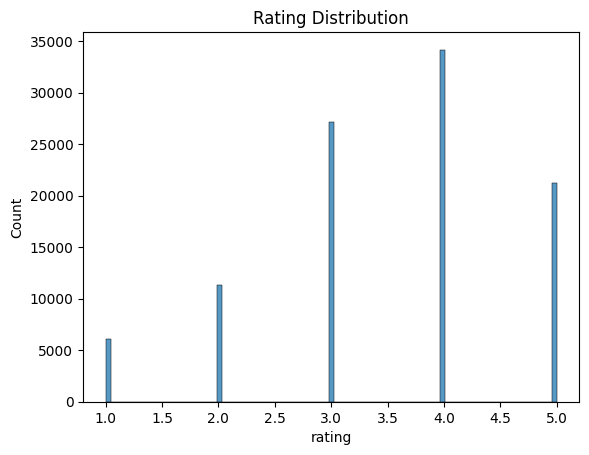

In [87]:
from scipy.sparse import csr_matrix
# Basic EDA visualizations (e.g., rating distribution)
sns.histplot(df['rating'])
plt.title('Rating Distribution')
plt.show()

# User-Item Matrix Conversion
user_item_matrix = df.pivot_table(index='user_id', columns='item_id', values='rating').fillna(0)
sparse_user_item = csr_matrix(user_item_matrix.values)

In [91]:
pip install implicit --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 48.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [92]:
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import train_test_split as implicit_train_test_split
import implicit
# Train-Test Split (using implicit library's split for ALS)
train, test = implicit_train_test_split(sparse_user_item)

In [93]:
# Alternating Least Squares (ALS)
model_als = AlternatingLeastSquares(factors=50, regularization=0.01, iterations=20)
model_als.fit(train.T)


  0%|          | 0/20 [00:00<?, ?it/s]

In [97]:
# ALS Predictions using user and item factors dot product
def get_als_predictions(model, user_item_matrix, test):
    predictions = []
    actuals = []
    user_indices, item_indices = test.nonzero()

    # Create mappings for user and item IDs
    user_id_map = {user_id: index for index, user_id in enumerate(user_item_matrix.index)}
    item_id_map = {item_id: index for index, item_id in enumerate(user_item_matrix.columns)}

    for user_index, item_index in zip(user_indices, item_indices):
        user_id = user_item_matrix.index[user_index]
        item_id = user_item_matrix.columns[item_index]

        if user_id in user_id_map and item_id in item_id_map:
            mapped_user_index = user_id_map[user_id]
            mapped_item_index = item_id_map[item_id]

            # Bounds check for item index
            if mapped_item_index < model.item_factors.shape[0]:
                user_factors = model.user_factors[mapped_user_index]
                item_factors = model.item_factors[mapped_item_index]
                predicted_rating = np.dot(user_factors, item_factors)
                actual_rating = user_item_matrix.iloc[user_index, item_index]
                predictions.append(predicted_rating)
                actuals.append(actual_rating)
            else:
                print(f"Warning: Item {item_id} index out of bounds in ALS model.")
        else:
            print(f"Warning: User {user_id} or Item {item_id} not in ALS model.")

    return predictions, actuals


als_predictions, als_actuals = get_als_predictions(model_als, user_item_matrix, test)

**Matrix Factorization (SVD)**

In [ ]:
# Create user-item matrix
user_item_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating')
print(f"User-item matrix shape: {user_item_matrix.shape}")

# Normalize ratings by subtracting user mean
user_mean = ratings.groupby('user_id')['rating'].mean()
normalized_ratings = ratings.copy()
normalized_ratings['rating'] = normalized_ratings.apply(lambda x: x['rating'] - user_mean[x['user_id']], axis=1)
normalized_matrix = normalized_ratings.pivot(index='user_id', columns='item_id', values='rating')
normalized_matrix.fillna(0, inplace=True)

**Neural Collaborative Filtering (NCF)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# Prepare data for NCF
X = ratings[['user_id', 'item_id']].values
y = ratings['rating'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Number of users and items
n_users = ratings['user_id'].nunique()
n_items = ratings['item_id'].nunique()

# NCF model
user_input = Input(shape=(1,))
item_input = Input(shape=(1,))

user_embedding = Embedding(n_users, 50)(user_input)
item_embedding = Embedding(n_items, 50)(item_input)

user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

concat = Concatenate()([user_vec, item_vec])
dense = Dense(128, activation='relu')(concat)
output = Dense(1)(dense)

model = Model([user_input, item_input], output)
model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit([X_train[:,0], X_train[:,1]], y_train, 
                    batch_size=64, epochs=10, 
                    validation_data=([X_test[:,0], X_test[:,1]], y_test))

# Predictions
ncf_predictions = model.predict([X_test[:,0], X_test[:,1]]).flatten()